# 0. Librerias

In [1]:
# Genérica
# -----------------------------------------------------------------------------
from time import time
import session_info


# Tratamientos datos
# -----------------------------------------------------------------------------
import json
import pandas as pd
pd.set_option('display.max_columns', None)

import numpy as np


# category encoders
# -----------------------------------------------------------------------------
from category_encoders import OrdinalEncoder


# scikit-learn
# -----------------------------------------------------------------------------
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, FunctionTransformer
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score


# LightGBM
# -----------------------------------------------------------------------------
import lightgbm as lgb


# Gráficos
# -----------------------------------------------------------------------------
import seaborn as sns
import matplotlib.pyplot as plt


session_info.show(html=False)

-----
category_encoders   2.6.1
lightgbm            3.3.5
matplotlib          3.7.2
numpy               1.23.5
pandas              1.5.3
seaborn             0.12.2
session_info        1.0.0
sklearn             1.3.0
-----
IPython             8.14.0
jupyter_client      8.3.0
jupyter_core        5.3.1
notebook            6.5.4
-----
Python 3.10.11 (main, May 16 2023, 00:28:57) [GCC 11.2.0]
Linux-5.15.0-107-generic-x86_64-with-glibc2.31
-----
Session information updated at 2024-05-17 12:31


In [2]:
# Funciones
# -----------------------------------------------------------------------------
def optimize_df_dtypes(df):

    variables_categoricas = [
        'Epoca_Covid',
        'Anio',
        'Trimestre',
        'Mes',
        'Negocio',
        'Cliente',
        'Tipo_Cliente',
        'Distribuidor_MSM',
        'Codigo_Postal',
        'Area_Dist',
        'Zona',
        'ID_CCAA',
        'Comunidad_Autonoma',
        'ID_Provincia',
        'Provincia',
        'Gama',
        'Descripcion_Gama',
        'Formato_1',
        'Formato_2',
        'Dureza_Agua'
    ]
    
    variables_enteras = [
        'Num_PdV_CI',
        'Num_PdV_RU', 
        'Num_PdV_TU', 
        'Impactos_TV', 
        'Sell_In_PP', 
        'Marketing_Nacional', 
        'Trade_Marketing', 
        'Marketing_PLV',
        'Dispersion_PdV',
        'Volumen_Solicitado',
        'Tarifa_Eur_Hl', 
        'Margen_Distribuidor', 
        'Egatur', 
        'Familitur',
        'Num_Manantiales',
        'Sell_In_1', 
        'Sell_In'
    ]
    
    variables_decimales = [
        'IPC', 
        'IPRI', 
        'Temperatura_Media', 
        'Precipitacion',
        'Nivel_Embalses'
        # 'Stock'
    ]

    for i in df.columns:
        if i in variables_categoricas:
            df[i] = df[i].astype('category')
        elif i in variables_enteras:
            df[i] = df[i].astype('int')
        elif i in variables_decimales:
            df[i] = df[i].astype('float')
        else:
            pass
 
    fcols = df.select_dtypes('float').columns
    icols = df.select_dtypes('integer').columns

    df[fcols] = df[fcols].apply(pd.to_numeric, downcast='float')
    df[icols] = df[icols].apply(pd.to_numeric, downcast='integer')

    return df 

# 1. Cargar datos

In [3]:
# Ruta
path = './data/si-train-5.csv'

# Cargar datos, especificando los dtypes para cada columna
df = pd.read_csv(path, sep=';')

# Optimizar tipo dato
df = optimize_df_dtypes(df)

# Dataset completo (copia seguridad)
df_complete = df.copy()

# Dataset de validación final
filter_val = ((df.Fecha >= 202402) & (df.Fecha <= 202403)) 
df_val = df[filter_val].reset_index(drop=True)

# Dataset de entrenamiento
filter_train = (df.Fecha <= 202401)
df = df[filter_train].reset_index(drop=True)

df.head()

/tmp/ipykernel_113957/598695441.py:5: DtypeWarning: Columns (7) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(path, sep=';')


,Fecha,Epoca_Covid,Anio,Mes,Negocio,Cliente,Tipo_Cliente,Codigo_Postal,Area_Dist,ID_Provincia,Provincia,ID_CCAA,Comunidad_Autonoma,Gama,Descripcion_Gama,Formato_1,Formato_2,Num_PdV_CI,Num_PdV_RU,Num_PdV_TU,Impactos_TV,Sell_In_PP,Marketing_Nacional,Trade_Marketing,Marketing_PLV,Dispersion_PdV,Volumen_Solicitado,Tarifa_Eur_Hl,Margen_Distribuidor,Egatur,Familitur,IPC,IPRI,Temperatura_Media,Precipitacion,Num_Manantiales,Nivel_Embalses,Dureza_Agua,Sell_In_1,Sell_In,STRATIO_CREATED_DATE,exec_month
0,201711,pre-covid,2017,11,UNE,698650,CON,3725,Y2,3,ALICANTE,10,COMUNIDAD VALENCIANA,MH,Mahou,No retornable,Lata,0,60,459,0,0,130,39,64,32,0,325,27,415,0,0.5,101.809998,11.32,12.1,0,28.73,Muy dura,18,21,2024-05-14T13:57:42.649Z,202404
1,201711,pre-covid,2017,11,UNE,698650,CON,3725,Y2,3,ALICANTE,10,COMUNIDAD VALENCIANA,MH,Mahou,No retornable,Tercio SR,0,60,459,0,0,-63,-3187,33,32,0,505,56,415,0,0.5,101.809998,11.32,12.1,0,28.73,Muy dura,23,12,2024-05-14T13:57:42.649Z,202404
2,201711,pre-covid,2017,11,UNE,698650,CON,3725,Y2,3,ALICANTE,10,COMUNIDAD VALENCIANA,MH,Mahou,Retornable,Quinto,0,60,459,0,0,387,120,158,32,0,378,65,415,0,0.5,101.809998,11.32,12.1,0,28.73,Muy dura,84,50,2024-05-14T13:57:42.649Z,202404
3,201711,pre-covid,2017,11,UNE,698650,CON,3725,Y2,3,ALICANTE,10,COMUNIDAD VALENCIANA,MH,Mahou,Retornable,Tercio,0,60,459,0,0,3450,1073,1247,32,0,380,51,415,0,0.5,101.809998,11.32,12.1,0,28.73,Muy dura,543,433,2024-05-14T13:57:42.649Z,202404
4,201711,pre-covid,2017,11,UNE,698650,CON,3725,Y2,3,ALICANTE,10,COMUNIDAD VALENCIANA,SM,San Miguel,Barril,Barril,0,1,4,0,0,0,0,0,32,0,359,32,415,0,0.5,101.809998,11.32,12.1,0,28.73,Muy dura,0,0,2024-05-14T13:57:42.649Z,202404


## 1.1. EDA

In [4]:
# DTypes
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2788784 entries, 0 to 2788783
Data columns (total 42 columns):
 #   Column                Dtype   
---  ------                -----   
 0   Fecha                 int32   
 1   Epoca_Covid           category
 2   Anio                  category
 3   Mes                   category
 4   Negocio               category
 5   Cliente               category
 6   Tipo_Cliente          category
 7   Codigo_Postal         category
 8   Area_Dist             category
 9   ID_Provincia          category
 10  Provincia             category
 11  ID_CCAA               category
 12  Comunidad_Autonoma    category
 13  Gama                  category
 14  Descripcion_Gama      category
 15  Formato_1             category
 16  Formato_2             category
 17  Num_PdV_CI            int16   
 18  Num_PdV_RU            int16   
 19  Num_PdV_TU            int16   
 20  Impactos_TV           int32   
 21  Sell_In_PP            int16   
 22  Marketing_Nacional

In [5]:
# Separar datasets
dates_complete = df_complete['Fecha'].nunique()
dates_train = df['Fecha'].nunique()
dates_val = df_val['Fecha'].nunique()

print(f"Fechas totales: {dates_complete}")
print(f"Fechas entrenamiento: {dates_train}")
print(f"Fechas validación: {dates_val}")

Fechas totales: 72
Fechas entrenamiento: 70
Fechas validación: 2


In [6]:
sorted(df['Fecha'].unique())

[201610,
 201611,
 201612,
 201701,
 201702,
 201703,
 201704,
 201705,
 201706,
 201707,
 201708,
 201709,
 201710,
 201711,
 201712,
 201801,
 201802,
 201803,
 201804,
 201805,
 201806,
 201807,
 201808,
 201809,
 201810,
 201811,
 201812,
 201901,
 201902,
 201903,
 201904,
 201905,
 201906,
 201907,
 201908,
 201909,
 201910,
 201911,
 201912,
 202001,
 202002,
 202109,
 202110,
 202111,
 202112,
 202201,
 202202,
 202203,
 202204,
 202205,
 202206,
 202207,
 202208,
 202209,
 202210,
 202211,
 202212,
 202301,
 202302,
 202303,
 202304,
 202305,
 202306,
 202307,
 202308,
 202309,
 202310,
 202311,
 202312,
 202401]

In [7]:
# Conteo por Negocio
df['Negocio'].value_counts()

UNE    2137034
UNA     651750
Name: Negocio, dtype: int64

In [8]:
# Conteo por Formato_1
df[['Negocio', 'Formato_1']].value_counts()

Negocio  Formato_1    
UNE      No retornable    1154996
         Retornable        517950
UNA      No retornable     509549
UNE      Barril            464088
UNA      Retornable        142133
         Barril                68
dtype: int64

In [9]:
# Conteo por Negocio-Formato_2
df[['Negocio', 'Formato_2']].value_counts()

Negocio  Formato_2       
UNE      Tercio SR           555441
         Barril              441829
         Tercio              367106
         Lata                361782
UNA      PET 0,50 L          152629
UNE      Quinto              150844
         Cuarto SR           105431
UNA      PET 1,50 L           94644
         PET 0,33 L           91030
         MEDIO LITRO          77118
UNE      Gran Formato         65539
UNA      LITRO                51564
         TERCIO SR            49111
UNE      Medio Litro SR       47259
UNA      PET 5,00 L           36446
         PET 1,00 L           23351
UNE      Duotank              22259
UNA      PET 0,75 L           19809
UNE      Quinto SR            16378
UNA      GRAN FORMATO         13853
         Lata                 11450
         PET GRAN FORMATO      9765
         CR 0,33 L             6454
         CUARTO SR             6183
         CR 0,75 L             6102
UNE      Bag in Box            3166
UNA      11 Litros              807
  

In [10]:
# Eliminar columnas genéricas para todos los experimentos
df = df.drop(columns=[
    'Fecha',
    'Anio',
    'Cliente',
    'Codigo_Postal',
    'Provincia',
    'ID_CCAA',
    'Comunidad_Autonoma',
    'Descripcion_Gama',
    'STRATIO_CREATED_DATE',
    'exec_month'
])

In [11]:
# Contar el número de NaN por columna
num_nan_por_columna = df.isna().sum()
print(num_nan_por_columna)

Epoca_Covid            0
Mes                    0
Negocio                0
Tipo_Cliente           0
Area_Dist              0
ID_Provincia           0
Gama                   0
Formato_1              0
Formato_2              0
Num_PdV_CI             0
Num_PdV_RU             0
Num_PdV_TU             0
Impactos_TV            0
Sell_In_PP             0
Marketing_Nacional     0
Trade_Marketing        0
Marketing_PLV          0
Dispersion_PdV         0
Volumen_Solicitado     0
Tarifa_Eur_Hl          0
Margen_Distribuidor    0
Egatur                 0
Familitur              0
IPC                    0
IPRI                   0
Temperatura_Media      0
Precipitacion          0
Num_Manantiales        0
Nivel_Embalses         0
Dureza_Agua            0
Sell_In_1              0
Sell_In                0
dtype: int64


In [12]:
# Variable dependiente
target = 'Sell_In'

# Variables independientes
features = list(df.columns)
features.remove(target)

# Variables categóricas
categorical_features = [col for col in df.columns if df[col].dtype == 'category']

# Mostrar
print(f'Variables dependiente: 1')
print(f'{target}')
print(30*'-')
print(f'Variables independientes: {len(features)}')
print(f'{features}')
print(30*'-')
print(f'Variables categóricas: {len(categorical_features)}')
print(f'{categorical_features}')

Variables dependiente: 1
Sell_In
------------------------------
Variables independientes: 31
['Epoca_Covid', 'Mes', 'Negocio', 'Tipo_Cliente', 'Area_Dist', 'ID_Provincia', 'Gama', 'Formato_1', 'Formato_2', 'Num_PdV_CI', 'Num_PdV_RU', 'Num_PdV_TU', 'Impactos_TV', 'Sell_In_PP', 'Marketing_Nacional', 'Trade_Marketing', 'Marketing_PLV', 'Dispersion_PdV', 'Volumen_Solicitado', 'Tarifa_Eur_Hl', 'Margen_Distribuidor', 'Egatur', 'Familitur', 'IPC', 'IPRI', 'Temperatura_Media', 'Precipitacion', 'Num_Manantiales', 'Nivel_Embalses', 'Dureza_Agua', 'Sell_In_1']
------------------------------
Variables categóricas: 10
['Epoca_Covid', 'Mes', 'Negocio', 'Tipo_Cliente', 'Area_Dist', 'ID_Provincia', 'Gama', 'Formato_1', 'Formato_2', 'Dureza_Agua']


## 1.2. Test funcionales

In [13]:
def test_ok():
    print("\033[92m" + 13*"-" + "\033[0m")
    print("\033[92m" + "-- Test OK --" + "\033[0m")
    print("\033[92m" + 13*"-" + "\033[0m")
    
def test_ko():
    print("\033[91m" + 13*"-" + "\033[0m")
    print("\033[91m" + "-- Test KO --" + "\033[0m")
    print("\033[91m" + 13*"-" + "\033[0m")

In [14]:
# Todos los DHC tienen el área ZZ
prueba = (df_complete.Tipo_Cliente == 'DHC') & (df_complete.Area_Dist != 'ZZ')

if df[prueba].shape[0] == 0:
    test_ok()
else:
    test_ko()
    print(df_complete[['Cliente', 'Tipo_Cliente', 'Area_Dist']][prueba].drop_duplicates().head(5))

-------------
-- Test OK --
-------------


/tmp/ipykernel_113957/1917702575.py:4: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if df[prueba].shape[0] == 0:


# 2. MLflow

In [15]:
# Importar MLflow
import mlflow
from mlflow.models import ModelSignature
from mlflow.types.schema import Schema, ColSpec

In [16]:
# Ver ruta actual desde donde se va a levantar el MLflow server
!pwd

/home/gmachin/git/personal/project-sell-in-forecast


In [17]:
# Iniciar un servidor de MLflow con alguno de los dos comandos siguientes en una terminal
# $ mlflow server --host 127.0.0.1 --port 5000
# $ mlflow ui

In [18]:
# Apuntar el notebook al servidor MLflow levantado en la celda anterior
mlflow.set_tracking_uri("http://127.0.0.1:5000")

In [61]:
# Crear un experimento
# --------------------------------------------------

# Nombre
experiment_name = "MSM_Sell_In_Modelos_Formato_Fase5"

# Descripción
experiment_description = (
    "Proyecto de comparación de modelos de Sell In en función del Negocio y el Formato2."
)

# Etiquetas del experimento
experiment_tags = {
    "project_name": "Modelos-Sell-In",
    "problem_type": "Regresión",
    "client": "MSM",
    "mlflow.note.content": experiment_description,
}

# Crear el experimento
produce_sell_in_experiment = mlflow.create_experiment(
    name=experiment_name,
    tags=experiment_tags
)

# Activar el experimento
mlflow.set_experiment(experiment_name)

<Experiment: artifact_location='mlflow-artifacts:/385982964012011333', creation_time=1715690019527, experiment_id='385982964012011333', last_update_time=1715690019527, lifecycle_stage='active', name='MSM_Sell_In_Modelos_Formato_Fase5', tags={'client': 'MSM',
 'mlflow.note.content': 'Proyecto de comparación de modelos de Sell In en '
                        'función del Negocio y el Formato2.',
 'problem_type': 'Regresión',
 'project_name': 'Modelos-Sell-In'}>

# 3. Modelos

## 3.1. Funciones

### 3.1.1. Entrenar modelo

In [27]:
# Función que entrena el modelo con un dataset de entrada, y unos parámetros
# definidos por el usuario, logga el modelo entrenado y las métricas en MLflow,
# y devuelve la URI del modelo en el MLflow server.
# -----------------------------------------------------------------------------
def execute_model(df, seed, model_params):

    # Medir tiempo
    tiempo_inicial = time()


    # Dataset de test y entrenamiento
    # --------------------------------------------------------------------------
    # Variable dependiente
    target = 'Sell_In'

    # Variables independientes
    features = list(df.columns)
    features.remove(target)

    # Variables categóricas
    categorical_features = [col for col in df.columns if df[col].dtype == 'category']

    # Dataset de test y entrenamiento
    train, test = train_test_split(
        df,
        train_size=0.95,
        test_size=0.05,
        stratify=df['Formato_2'],
        random_state=seed
    )



    # MLflow
    # --------------------------------------------------------------------------
    # Activar el experimento
    mlflow.set_experiment(experiment_name)

    # Lanzar ejecución de MLflow
    with mlflow.start_run(run_name=run_name) as run:

        # UUID del experimento
        experiment_id = run.info.experiment_id

        # UUID de la ejecución
        run_id = run.info.run_uuid

        # Instanciar OrdinalEncoder
        encoder = OrdinalEncoder(
            cols=categorical_features,
            handle_unknown="ignore",
            return_df=True
        )
        

        # Instanciar LGBMRegressor
        mlgb = lgb.LGBMRegressor(**model_params)


        # Pipeline: Encoder + Regresor
        model_pipeline = Pipeline([
            ("encoder", encoder),
            ("mlgb", mlgb)
        ])


        # Entrenar modelo
        model = model_pipeline.fit(train[features], train[target])


        # Cálculo de métricas
        train_y_real = train[target]
        train_y_pred = model.predict(train[features])

        test_y_real = test[target]
        test_y_pred = model.predict(test[features])

        metric_r2_train = round(r2_score(train_y_real, train_y_pred), 3)
        metric_r2_test = round(r2_score(test_y_real, test_y_pred), 3)

        metric_r2_adj_train = round(1-(1-metric_r2_train)*(len(test)-1)/(len(test)-len(features)-1), 3)
        metric_r2_adj_test = round(1-(1-metric_r2_test)*(len(test)-1)/(len(test)-len(features)-1), 3)

        metric_train_mae = round(mean_absolute_error(train_y_real, train_y_pred), 3)
        metric_test_mae = round(mean_absolute_error(test_y_real, test_y_pred), 3)

        metric_train_rmse = round(mean_squared_error(train_y_real, train_y_pred, squared=False), 3)
        metric_test_rmse = round(mean_squared_error(test_y_real, test_y_pred, squared=False), 3)

        metric_train_score = round(1.00 - (metric_train_mae / train_y_real.mean()), 3)
        metric_test_score = round(1.00 - (metric_test_mae / test_y_real.mean()), 3)


        # Genere un diccionario con las métricas
        metrics = {
            "r2_train": metric_r2_train,
            "r2_test": metric_r2_test,
            "r2_adj_train": metric_r2_adj_train,
            "r2_adj_test": metric_r2_adj_test,
            "mae_train": metric_train_mae,
            "mae_test": metric_test_mae,
            "rmse_train": metric_train_rmse,
            "rmse_test": metric_test_rmse,
            "score_train": metric_train_score,
            "score_test": metric_test_score
        }


        # Loggar parámetros
        mlflow.log_params(model_params)

        # Logar métricas
        mlflow.log_metrics(metrics)

        # Schema input/output del modelo
        input_schema = Schema([
            ColSpec("string", "Epoca_Covid"),
            ColSpec("string", "Mes"),
            ColSpec("string", "Negocio"),
            ColSpec("string", "Tipo_Cliente"),
            ColSpec("string", "Area_Dist"),
            ColSpec("string", "ID_Provincia"),
            ColSpec("string", "Gama"),
            ColSpec("string", "Formato_1"),
            ColSpec("string", "Formato_2"),
            ColSpec("integer", "Num_PdV_CI"),
            ColSpec("integer", "Num_PdV_RU"),
            ColSpec("integer", "Num_PdV_TU"),
            ColSpec("integer", "Impactos_TV"),
            ColSpec("integer", "Sell_In_PP"),
            ColSpec("integer", "Marketing_Nacional"),
            ColSpec("integer", "Trade_Marketing"),
            ColSpec("integer", "Marketing_PLV"),
            ColSpec("integer", "Dispersion_PdV"),
            ColSpec("integer", "Volumen_Solicitado"),
            ColSpec("long", "Tarifa_Eur_Hl"),
            ColSpec("integer", "Margen_Distribuidor"),
            ColSpec("integer", "Egatur"),
            ColSpec("integer", "Familitur"),
            ColSpec("float", "IPC"),
            ColSpec("float", "IPRI"),
            ColSpec("float", "Temperatura_Media"),
            ColSpec("float", "Precipitacion"),
            ColSpec("integer", "Num_Manantiales"),
            ColSpec("float", "Nivel_Embalses"),
            ColSpec("string", "Dureza_Agua"),
            ColSpec("integer", "Sell_In_1")
        ])

        output_schema = Schema([ColSpec("float", "prediction")])

        signature = ModelSignature(inputs=input_schema, outputs=output_schema)

        # Log modelo entrenado
        mlflow.sklearn.log_model(model, model_name, signature=signature)

    
    # Medir tiempo
    tiempo_final = time()
    tiempo_ejecucion = tiempo_final - tiempo_inicial

    print("")
    print("")
    print(f"Entrenamiento:")
    print(50*"-")
    print(f"Tiempo de ejecución: {tiempo_ejecucion/60} minutos")


    # Info del modelo loggado
    print("")
    print("")
    print(f"MLflow:")
    print(50*"-")
    print(f"- Modelo loggado en el experimento: {experiment_id} --> {experiment_name}")
    print(f"- Modelo loggado en la ejecución: {run_id} --> {run_name}")
    print(f"- Nombre del modelo: {model_name}")
    print("")
    print(f"- URI del modelo: 'runs:/{run_id}/{model_name}'")

    model_uri = f'runs:/{run_id}/{model_name}'
    
    
    # Mostrar parámetros de entrenamiento
    print("")
    print("")
    print(f"Parámetros de entrenamiento:")
    print(50*"-")
    print(json.dumps(model_params, indent=4))
    
    
    # Mostrar métricas
    print("")
    print("")
    print(f"Métricas:")
    print(50*"-")
    print(json.dumps(metrics, indent=4))
    
    
    return model_uri, metrics

### 3.1.2. Generar predicciones

In [20]:
# Función que dada la uri de un modelo de MLflow, y un dataframe, genera las
# predicciones del dataframe, y calcula el % de error de cada registro.
# -----------------------------------------------------------------------------
def execute_analysis(df, model_uri):
    
    # Cargar modelo como PyFuncModel
    print("")
    print(f"MLflow:")
    print(50*"-")
    print(f"- URI del modelo: {model_uri}")
    loaded_model = mlflow.pyfunc.load_model(model_uri)
    
    
    # Lista de variables dependientes
    print("")
    print("")
    print(f"Variables dependientes:")
    print(50*"-")
    print(f"Se le pasan al modelo {len(features)} variables dependientes:")
    print(f"{features}")


    # Castear las columnas de tipo category a object
    categorical_columns = df.select_dtypes(include=['category']).columns
    df[categorical_columns] = df[categorical_columns].astype('object')

    
    # Predicción
    predictions = pd.Series(
        loaded_model.predict(df[features]),
        name='Sell_In_Pred'
        )

    
    # Columnas del análisis
    df_analysis = df[['Negocio', 'Area_Dist', 'Formato_1', 'Formato_2', 'Sell_In']].copy()
    df_analysis['Formato'] = df_analysis['Formato_1'] + ' - ' + df_analysis['Formato_2']

    
    # Concatenar dataset anterior con las predicciones
    df_analysis = pd.concat([df_analysis, predictions], axis=1)

    
    # Agregar el dato por Fecha, Area y Formato
    df_analysis = df_analysis.groupby(['Negocio', 'Area_Dist', 'Formato_1', 'Formato_2', 'Formato'], as_index=False) \
                             .sum(['Sell_In', 'Sell_In_Pred'])
    
    
    # Calcular el error en %
    df_analysis['Desviacion'] = round((df_analysis.Sell_In_Pred - df_analysis.Sell_In)*100 / df_analysis.Sell_In, 2)


    return df_analysis

### 3.1.3. Pintar Heatmap

In [21]:
# Función que dado un dataframe, y el negocio, genera un mapa de calor.
# -----------------------------------------------------------------------------
def plot_heatmap(df, negocio):
    
    if negocio=='UNE':
        orden = [
            'Barril - Barril',
            'Retornable - Tercio',
            'Retornable - Quinto',
            'No retornable - Lata',
            'No retornable - Tercio SR',
            'No retornable - Gran Formato',
            'No retornable - Cuarto SR',
            'Barril - Duotank',
            'No retornable - Quinto SR',
            'No retornable - Bag in Box'
        ]
    else:
        orden = [
            'No retornable - PET 1,50 L',
            'No retornable - PET 0,50 L',
            'No retornable - PET GRAN FORMATO',
            'Retornable - LITRO',
            'Retornable - MEDIO LITRO',
            'No retornable - PET 0,33 L',
            'No retornable - PET 5,00 L',
            'No retornable - TERCIO SR',
            'No retornable - PET 1,00 L',
            'No retornable - Lata',
            'No retornable - PET 0,75 L',
            'Retornable - 20 Litros',
            'No retornable - GRAN FORMATO',
            'Retornable - CR 0,75 L',
            'Retornable - 11 Litros',
            'Retornable - CR 0,33 L'
        ]
        
        
    # Pivot
    # --------------------------------------------------------------------------
    df_desviaciones = df[df.Negocio==negocio].pivot_table(
        index='Area_Dist',
        columns=['Formato'],
        values='Desviacion',
        aggfunc='mean'
        )


    # Cambiar el tamaño del mapa de calor
    # --------------------------------------------------------------------------
    num_filas, num_columnas = df_desviaciones[orden].shape
    tamaño_ancho = num_columnas * 1
    tamaño_alto = num_filas * 0.5

    plt.figure(figsize=(tamaño_ancho, tamaño_alto))

    # Mapa de calor
    sns.heatmap(
        df_desviaciones[orden],
        annot=True,
        fmt=".2f",
        cmap='RdYlGn',
        vmin=-100,
        vmax=100,
        linewidth=.5
    )

    # Mostrar el mapa de calor
    plt.title('Mapa de Calor de Desviaciones')
    plt.xlabel('Formato')
    plt.ylabel('Area')

    plt.show()

## 3.2. LightGBM - Modelo Global

El alcance de este experimento es:

**Modelo Global:**
- Negocio: UNE + UNA
- Formatos: Todos

### 3.2.1. Entrenamiento

In [28]:
# Variables de ejecución MLflow
# ------------------------------------------------------------------------------------
experiment_name = 'MSM_Sell_In_Modelos_Formato_Fase5'
run_name = 'Modelo_LightGBM_Experiment_Global'
model_name = 'lightgbm-model-global'


# Dataset de test y entrenamiento
# ------------------------------------------------------------------------------------
# Copia del dataset para el experimento
df_exp = df.copy()

# Filtrar por ...
#filtro = df.Gama=='AL'
#df_exp = df_exp[filtro]


# Entrenar modelo, loggar en MLflow y obtener URI del modelo loggado
# ------------------------------------------------------------------------------------
# Parámetros
seed = 123

model_params = {
    "boosting_type": "gbdt",
    "learning_rate": 0.1,
    "n_estimators": 1000,
    "max_depth": 10,
    "num_leaves": 350,
    "min_child_samples": 20,
    "bagging_fraction": 1.0,
    "bagging_freq": 0,
    "feature_fraction": 0.8,
    "reg_sqrt": True,
    "feature_pre_filter": False,
    "random_state": seed,
    "n_jobs": -1
}

# Entrenar modelo
uri_lgb_global, metrics_global = execute_model(df_exp, seed, model_params)

[LightGBM] [Warning] bagging_fraction is set=1.0, subsample=1.0 will be ignored. Current value: bagging_fraction=1.0
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


Entrenamiento:
--------------------------------------------------
Tiempo de ejecución: 3.9822099685668944 minutos


MLflow:
--------------------------------------------------
- Modelo loggado en el experimento: 385982964012011333 --> MSM_Sell_In_Modelos_Formato_Fase5
- Modelo loggado en la ejecución: 3dbbfa1d9fce423e8cc3e1c7729eba4d --> Modelo_LightGBM_Experiment_Global
- Nombre del modelo: lightgbm-model-global

- URI del modelo: 'runs:/3dbbfa1d9fce423e8cc3e1c7729eba4d/lightgbm-model-global'


Parámetros de entrenamiento:
--------------------------------------------------
{
    "boosting_type": "gbdt",
    "learning_rate": 0.1,
    "n_estim

/home/gmachin/.cache/pypoetry/virtualenvs/msm-sell-in-prediction-unVKpS6j-py3.10/lib/python3.10/site-packages/_distutils_hack/__init__.py:18: UserWarning: Distutils was imported before Setuptools, but importing Setuptools also replaces the `distutils` module in `sys.modules`. This may lead to undesirable behaviors or errors. To avoid these issues, avoid using distutils directly, ensure that setuptools is installed in the traditional way (e.g. not an editable install), and/or make sure that setuptools is always imported before distutils.
  warnings.warn(
/home/gmachin/.cache/pypoetry/virtualenvs/msm-sell-in-prediction-unVKpS6j-py3.10/lib/python3.10/site-packages/_distutils_hack/__init__.py:33: UserWarning: Setuptools is replacing distutils.
  warnings.warn("Setuptools is replacing distutils.")


In [29]:
uri_lgb_global

'runs:/3dbbfa1d9fce423e8cc3e1c7729eba4d/lightgbm-model-global'

### 3.2.2. Predicciones dataset de validación

In [30]:
# Datasets
print(f"Fechas totales: {dates_complete}")
print(f"Fechas entrenamiento: {dates_train}")
print(f"Fechas validación: {dates_val}")

Fechas totales: 72
Fechas entrenamiento: 70
Fechas validación: 2


In [31]:
# Fechas del dataset de validación
sorted(df_val['Fecha'].unique())

[202402, 202403]

In [32]:
# Dataset para comprobar predicciones
df_val.head()

,Fecha,Epoca_Covid,Anio,Mes,Negocio,Cliente,Tipo_Cliente,Codigo_Postal,Area_Dist,ID_Provincia,Provincia,ID_CCAA,Comunidad_Autonoma,Gama,Descripcion_Gama,Formato_1,Formato_2,Num_PdV_CI,Num_PdV_RU,Num_PdV_TU,Impactos_TV,Sell_In_PP,Marketing_Nacional,Trade_Marketing,Marketing_PLV,Dispersion_PdV,Volumen_Solicitado,Tarifa_Eur_Hl,Margen_Distribuidor,Egatur,Familitur,IPC,IPRI,Temperatura_Media,Precipitacion,Num_Manantiales,Nivel_Embalses,Dureza_Agua,Sell_In_1,Sell_In,STRATIO_CREATED_DATE,exec_month
0,202402,post-covid,2024,2,UNA,534689,DHC,28005,ZZ,99,NACIONAL,99,NACIONAL,AL,Alhambra,No retornable,"PET 0,50 L",0,0,0,0,1,0,0,0,0,0,53,0,992,0,0.4,116.099998,9.2,29.9,0,77.5,Media,3,4,2024-05-14T13:57:42.649Z,202404
1,202402,post-covid,2024,2,UNA,534689,DHC,28005,ZZ,99,NACIONAL,99,NACIONAL,AL,Alhambra,No retornable,"PET 1,50 L",0,0,0,0,0,0,0,0,0,0,33,0,992,0,0.4,116.099998,9.2,29.9,0,77.5,Media,0,0,2024-05-14T13:57:42.649Z,202404
2,202402,post-covid,2024,2,UNA,534690,DHC,28045,ZZ,99,NACIONAL,99,NACIONAL,AL,Alhambra,No retornable,"PET 0,50 L",0,0,0,0,2,0,0,0,0,0,53,0,992,0,0.4,116.099998,9.2,29.9,0,77.5,Media,3,4,2024-05-14T13:57:42.649Z,202404
3,202402,post-covid,2024,2,UNA,534691,DHC,28019,ZZ,99,NACIONAL,99,NACIONAL,AL,Alhambra,No retornable,"PET 0,50 L",0,0,0,0,2,0,0,0,0,0,52,0,992,0,0.4,116.099998,9.2,29.9,0,77.5,Media,3,2,2024-05-14T13:57:42.649Z,202404
4,202402,post-covid,2024,2,UNA,534691,DHC,28019,ZZ,99,NACIONAL,99,NACIONAL,AL,Alhambra,No retornable,"PET 1,00 L",0,0,0,0,0,0,0,0,0,0,33,0,992,0,0.4,116.099998,9.2,29.9,0,77.5,Media,0,0,2024-05-14T13:57:42.649Z,202404


In [33]:
df_val.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 73058 entries, 0 to 73057
Data columns (total 42 columns):
 #   Column                Non-Null Count  Dtype   
---  ------                --------------  -----   
 0   Fecha                 73058 non-null  int32   
 1   Epoca_Covid           73058 non-null  category
 2   Anio                  73058 non-null  category
 3   Mes                   73058 non-null  category
 4   Negocio               73058 non-null  category
 5   Cliente               73058 non-null  category
 6   Tipo_Cliente          73058 non-null  category
 7   Codigo_Postal         73058 non-null  category
 8   Area_Dist             73058 non-null  category
 9   ID_Provincia          73058 non-null  category
 10  Provincia             73058 non-null  category
 11  ID_CCAA               73058 non-null  category
 12  Comunidad_Autonoma    73058 non-null  category
 13  Gama                  73058 non-null  category
 14  Descripcion_Gama      73058 non-null  category
 15  Fo

In [34]:
# Dataset de validación: df_val
# Modelo de MLflow: uri_lgb_global
# -----------------------------------------------------------------------------
df_analysis = execute_analysis(df_val, uri_lgb_global)


MLflow:
--------------------------------------------------
- URI del modelo: runs:/3dbbfa1d9fce423e8cc3e1c7729eba4d/lightgbm-model-global




Variables dependientes:
--------------------------------------------------
Se le pasan al modelo 31 variables dependientes:
['Epoca_Covid', 'Mes', 'Negocio', 'Tipo_Cliente', 'Area_Dist', 'ID_Provincia', 'Gama', 'Formato_1', 'Formato_2', 'Num_PdV_CI', 'Num_PdV_RU', 'Num_PdV_TU', 'Impactos_TV', 'Sell_In_PP', 'Marketing_Nacional', 'Trade_Marketing', 'Marketing_PLV', 'Dispersion_PdV', 'Volumen_Solicitado', 'Tarifa_Eur_Hl', 'Margen_Distribuidor', 'Egatur', 'Familitur', 'IPC', 'IPRI', 'Temperatura_Media', 'Precipitacion', 'Num_Manantiales', 'Nivel_Embalses', 'Dureza_Agua', 'Sell_In_1']


In [35]:
df_analysis.head()

,Negocio,Area_Dist,Formato_1,Formato_2,Formato,Sell_In,Sell_In_Pred,Desviacion
0,UNA,Y0,No retornable,GRAN FORMATO,No retornable - GRAN FORMATO,175,117.127418,-33.07
1,UNA,Y0,No retornable,Lata,No retornable - Lata,242,309.467903,27.88
2,UNA,Y0,No retornable,"PET 0,33 L","No retornable - PET 0,33 L",689,701.871625,1.87
3,UNA,Y0,No retornable,"PET 0,50 L","No retornable - PET 0,50 L",12018,13688.173656,13.90
4,UNA,Y0,No retornable,"PET 0,75 L","No retornable - PET 0,75 L",1247,1701.132395,36.42


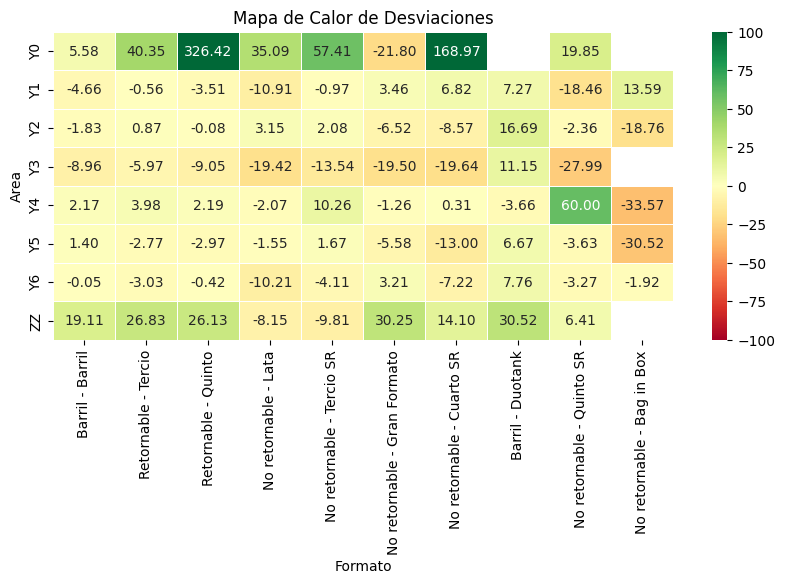

In [36]:
# Graficar mapa de calor de UNE
# -----------------------------------------------------------------------------
plot_heatmap(df_analysis, negocio='UNE')

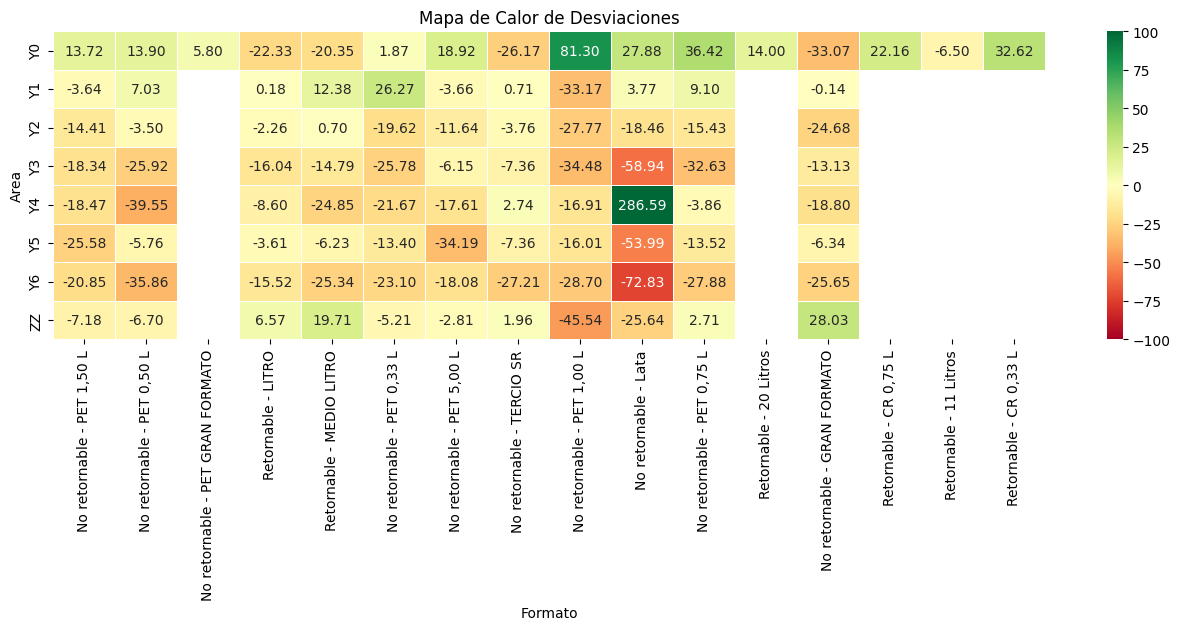

In [37]:
# Graficar mapa de calor de UNA
# -----------------------------------------------------------------------------
plot_heatmap(df_analysis, negocio='UNA')

## 3.3. LightGBM - Modelo UNE y UNA

El alcance de este experimento es:

**Modelo UNE:**
- Negocio: UNE
- Formatos: Todos

**Modelo UNA:**
- Negocio: UNA
- Formatos: Todos

### 3.3.1. Entrenamiento

#### 3.3.1.1. Modelo UNE

In [39]:
# Variables de ejecución MLflow
# ------------------------------------------------------------------------------------
experiment_name = 'MSM_Sell_In_Modelos_Formato_Fase5'
run_name = 'Modelo_LightGBM_Experiment_UNE'
model_name = 'lightgbm-model-une'


# Dataset de test y entrenamiento
# ------------------------------------------------------------------------------------
# Copia del dataset para el experimento
df_exp = df.copy()

# Filtrar por ...
filtro = df_exp.Negocio=='UNE'
df_exp = df_exp[filtro]


# Entrenar modelo, loggar en MLflow y obtener URI del modelo loggado
# ------------------------------------------------------------------------------------
# Parámetros
seed = 123

model_params = {
    "boosting_type": "gbdt",
    "learning_rate": 0.1,
    "n_estimators": 1000,
    "max_depth": 10,
    "num_leaves": 350,
    "min_child_samples": 20,
    "bagging_fraction": 1.0,
    "bagging_freq": 0,
    "feature_fraction": 0.8,
    "reg_sqrt": True,
    "feature_pre_filter": False,
    "random_state": seed,
    "n_jobs": -1
}

# Entrenar modelo
uri_lgb_une, metrics_une = execute_model(df_exp, seed, model_params)

[LightGBM] [Warning] bagging_fraction is set=1.0, subsample=1.0 will be ignored. Current value: bagging_fraction=1.0
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


Entrenamiento:
--------------------------------------------------
Tiempo de ejecución: 2.8376980066299438 minutos


MLflow:
--------------------------------------------------
- Modelo loggado en el experimento: 385982964012011333 --> MSM_Sell_In_Modelos_Formato_Fase5
- Modelo loggado en la ejecución: 70983bcb43cd423ab7dfc82ce2601a5f --> Modelo_LightGBM_Experiment_UNE
- Nombre del modelo: lightgbm-model-une

- URI del modelo: 'runs:/70983bcb43cd423ab7dfc82ce2601a5f/lightgbm-model-une'


Parámetros de entrenamiento:
--------------------------------------------------
{
    "boosting_type": "gbdt",
    "learning_rate": 0.1,
    "n_estimators": 1

/home/gmachin/.cache/pypoetry/virtualenvs/msm-sell-in-prediction-unVKpS6j-py3.10/lib/python3.10/site-packages/_distutils_hack/__init__.py:18: UserWarning: Distutils was imported before Setuptools, but importing Setuptools also replaces the `distutils` module in `sys.modules`. This may lead to undesirable behaviors or errors. To avoid these issues, avoid using distutils directly, ensure that setuptools is installed in the traditional way (e.g. not an editable install), and/or make sure that setuptools is always imported before distutils.
  warnings.warn(
/home/gmachin/.cache/pypoetry/virtualenvs/msm-sell-in-prediction-unVKpS6j-py3.10/lib/python3.10/site-packages/_distutils_hack/__init__.py:33: UserWarning: Setuptools is replacing distutils.
  warnings.warn("Setuptools is replacing distutils.")


#### 3.3.1.2. Modelo UNA

In [40]:
# Variables de ejecución MLflow
# ------------------------------------------------------------------------------------
experiment_name = 'MSM_Sell_In_Modelos_Formato_Fase5'
run_name = 'Modelo_LightGBM_Experiment_UNA'
model_name = 'lightgbm-model-una'


# Dataset de test y entrenamiento
# ------------------------------------------------------------------------------------
# Copia del dataset para el experimento
df_exp = df.copy()

# Filtrar por ...
filtro = df_exp.Negocio=='UNA'
df_exp = df_exp[filtro]


# Entrenar modelo, loggar en MLflow y obtener URI del modelo loggado
# ------------------------------------------------------------------------------------
# Parámetros
seed = 123

model_params = {
    "boosting_type": "gbdt",
    "learning_rate": 0.1,
    "n_estimators": 1000,
    "max_depth": 10,
    "num_leaves": 350,
    "min_child_samples": 20,
    "bagging_fraction": 1.0,
    "bagging_freq": 0,
    "feature_fraction": 0.8,
    "reg_sqrt": True,
    "feature_pre_filter": False,
    "random_state": seed,
    "n_jobs": -1
}

# Entrenar modelo
uri_lgb_una, metrics_una = execute_model(df_exp, seed, model_params)

[LightGBM] [Warning] bagging_fraction is set=1.0, subsample=1.0 will be ignored. Current value: bagging_fraction=1.0
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


Entrenamiento:
--------------------------------------------------
Tiempo de ejecución: 0.8144998788833618 minutos


MLflow:
--------------------------------------------------
- Modelo loggado en el experimento: 385982964012011333 --> MSM_Sell_In_Modelos_Formato_Fase5
- Modelo loggado en la ejecución: cd2511b69bdc488aa8c3325a48bd625d --> Modelo_LightGBM_Experiment_UNA
- Nombre del modelo: lightgbm-model-una

- URI del modelo: 'runs:/cd2511b69bdc488aa8c3325a48bd625d/lightgbm-model-una'


Parámetros de entrenamiento:
--------------------------------------------------
{
    "boosting_type": "gbdt",
    "learning_rate": 0.1,
    "n_estimators": 1

/home/gmachin/.cache/pypoetry/virtualenvs/msm-sell-in-prediction-unVKpS6j-py3.10/lib/python3.10/site-packages/_distutils_hack/__init__.py:18: UserWarning: Distutils was imported before Setuptools, but importing Setuptools also replaces the `distutils` module in `sys.modules`. This may lead to undesirable behaviors or errors. To avoid these issues, avoid using distutils directly, ensure that setuptools is installed in the traditional way (e.g. not an editable install), and/or make sure that setuptools is always imported before distutils.
  warnings.warn(
/home/gmachin/.cache/pypoetry/virtualenvs/msm-sell-in-prediction-unVKpS6j-py3.10/lib/python3.10/site-packages/_distutils_hack/__init__.py:33: UserWarning: Setuptools is replacing distutils.
  warnings.warn("Setuptools is replacing distutils.")


### 3.3.2. Predicciones dataset de validación

In [62]:
# Modelo:
# -----------------------------------------------------------------------------
# uri_lgb_une

# Dataset de validación:
# -----------------------------------------------------------------------------
filtro = df_val.Negocio=='UNE'
df_val_exp = df_val[filtro].reset_index(drop=True)

# Modelo de MLflow: uri_lgb_une
# -----------------------------------------------------------------------------
df_analysis_une = execute_analysis(df_val_exp, uri_lgb_une)


MLflow:
--------------------------------------------------
- URI del modelo: runs:/70983bcb43cd423ab7dfc82ce2601a5f/lightgbm-model-une




Variables dependientes:
--------------------------------------------------
Se le pasan al modelo 31 variables dependientes:
['Epoca_Covid', 'Mes', 'Negocio', 'Tipo_Cliente', 'Area_Dist', 'ID_Provincia', 'Gama', 'Formato_1', 'Formato_2', 'Num_PdV_CI', 'Num_PdV_RU', 'Num_PdV_TU', 'Impactos_TV', 'Sell_In_PP', 'Marketing_Nacional', 'Trade_Marketing', 'Marketing_PLV', 'Dispersion_PdV', 'Volumen_Solicitado', 'Tarifa_Eur_Hl', 'Margen_Distribuidor', 'Egatur', 'Familitur', 'IPC', 'IPRI', 'Temperatura_Media', 'Precipitacion', 'Num_Manantiales', 'Nivel_Embalses', 'Dureza_Agua', 'Sell_In_1']


In [63]:
# Modelo:
# -----------------------------------------------------------------------------
# uri_lgb_una

# Dataset de validación:
# -----------------------------------------------------------------------------
filtro = df_val.Negocio=='UNA'
df_val_exp = df_val[filtro].reset_index(drop=True)

# Modelo de MLflow: uri_lgb_une
# -----------------------------------------------------------------------------
df_analysis_una = execute_analysis(df_val_exp, uri_lgb_una)


MLflow:
--------------------------------------------------
- URI del modelo: runs:/cd2511b69bdc488aa8c3325a48bd625d/lightgbm-model-una




Variables dependientes:
--------------------------------------------------
Se le pasan al modelo 31 variables dependientes:
['Epoca_Covid', 'Mes', 'Negocio', 'Tipo_Cliente', 'Area_Dist', 'ID_Provincia', 'Gama', 'Formato_1', 'Formato_2', 'Num_PdV_CI', 'Num_PdV_RU', 'Num_PdV_TU', 'Impactos_TV', 'Sell_In_PP', 'Marketing_Nacional', 'Trade_Marketing', 'Marketing_PLV', 'Dispersion_PdV', 'Volumen_Solicitado', 'Tarifa_Eur_Hl', 'Margen_Distribuidor', 'Egatur', 'Familitur', 'IPC', 'IPRI', 'Temperatura_Media', 'Precipitacion', 'Num_Manantiales', 'Nivel_Embalses', 'Dureza_Agua', 'Sell_In_1']


In [64]:
# Concatenar los DataFrames
df_analysis = pd.concat([df_analysis_une, df_analysis_una], axis=0)

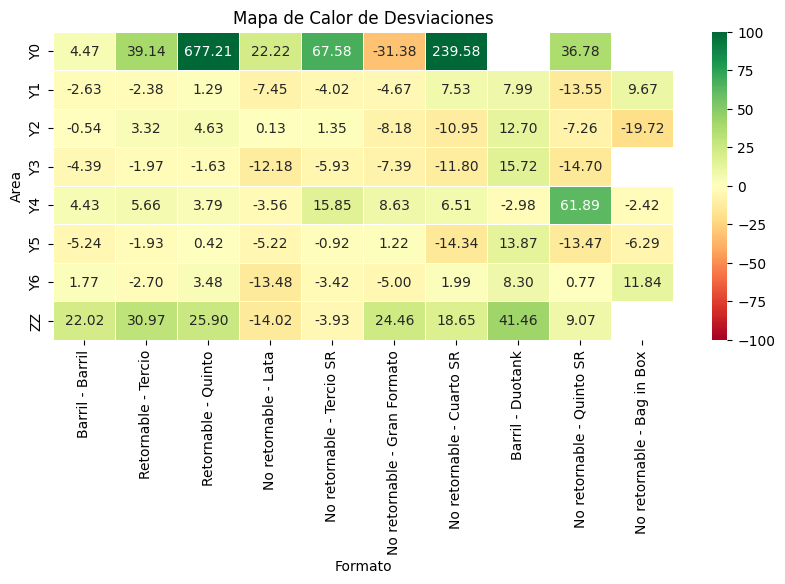

In [65]:
# Graficar mapa de calor de UNE
# -----------------------------------------------------------------------------
plot_heatmap(df_analysis, negocio='UNE')

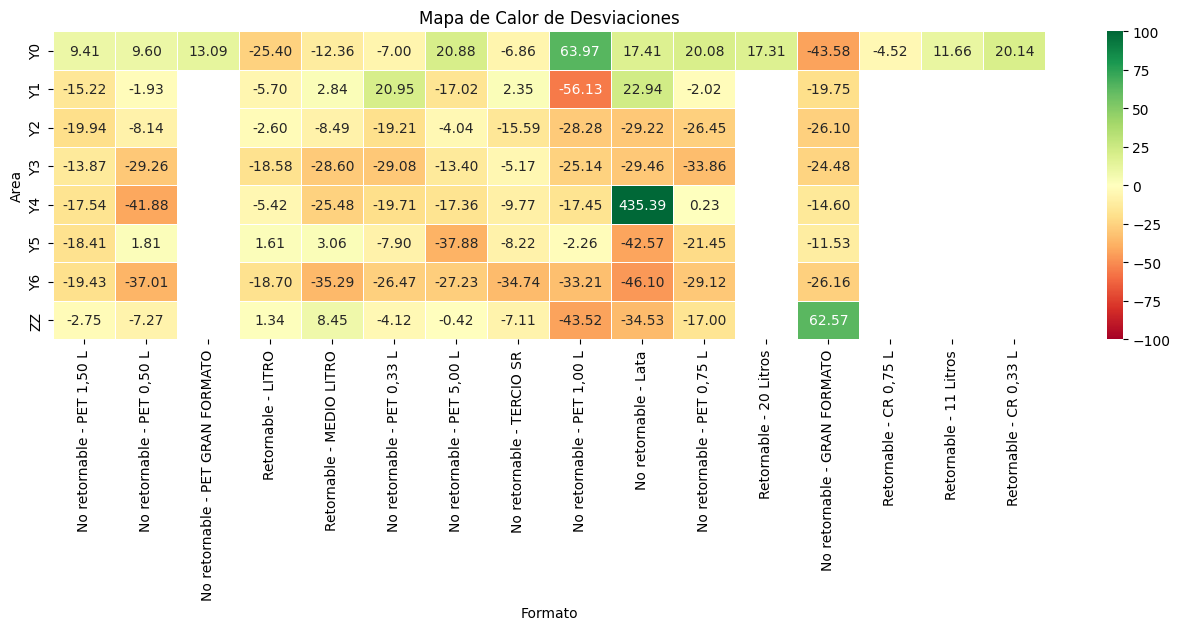

In [66]:
# Graficar mapa de calor de UNA
# -----------------------------------------------------------------------------
plot_heatmap(df_analysis, negocio='UNA')

## 3.4. LightGBM - Modelo UNE (Formato_1) y UNA (Formato_1)

El alcance de este experimento es:

**Modelo UNE - Formato_1:**
- Negocio: UNE
- Formatos: Barril, Retornable y No retornbale

**Modelo UNA - Formato_1:**
- Negocio: UNA
- Formatos: Barril, Retornable y No retornbale

### 3.4.1. Entrenamiento

#### 3.4.1.1. Modelo UNE-Barril

In [67]:
# Variables de ejecución MLflow
# ------------------------------------------------------------------------------------
experiment_name = 'MSM_Sell_In_Modelos_Formato_Fase5'
run_name = 'Modelo_LightGBM_Experiment_UNE_Barril'
model_name = 'lightgbm-model-une-barril'


# Dataset de test y entrenamiento
# ------------------------------------------------------------------------------------
# Copia del dataset para el experimento
df_exp = df.copy()

# Filtrar por:
filtro = (df_exp.Negocio=='UNE') & (df_exp.Formato_1=='Barril')
df_exp = df_exp[filtro]


# Entrenar modelo, loggar en MLflow y obtener URI del modelo loggado
# ------------------------------------------------------------------------------------
# Parámetros
seed = 123

model_params = {
    "boosting_type": "gbdt",
    "learning_rate": 0.1,
    "n_estimators": 1000,
    "max_depth": 10,
    "num_leaves": 350,
    "min_child_samples": 20,
    "bagging_fraction": 1.0,
    "bagging_freq": 0,
    "feature_fraction": 0.8,
    "reg_sqrt": True,
    "feature_pre_filter": False,
    "random_state": seed,
    "n_jobs": -1
}

# Entrenar modelo
uri_lgb_une_barril, metrics_une_barril = execute_model(df_exp, seed, model_params)

[LightGBM] [Warning] bagging_fraction is set=1.0, subsample=1.0 will be ignored. Current value: bagging_fraction=1.0
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


Entrenamiento:
--------------------------------------------------
Tiempo de ejecución: 1.451085631052653 minutos


MLflow:
--------------------------------------------------
- Modelo loggado en el experimento: 385982964012011333 --> MSM_Sell_In_Modelos_Formato_Fase5
- Modelo loggado en la ejecución: 67949fae37cd4fbf9813509ba9616f3f --> Modelo_LightGBM_Experiment_UNE
- Nombre del modelo: lightgbm-model-une

- URI del modelo: 'runs:/67949fae37cd4fbf9813509ba9616f3f/lightgbm-model-une'


Parámetros de entrenamiento:
--------------------------------------------------
{
    "boosting_type": "gbdt",
    "learning_rate": 0.1,
    "n_estimators": 10

/home/gmachin/.cache/pypoetry/virtualenvs/msm-sell-in-prediction-unVKpS6j-py3.10/lib/python3.10/site-packages/_distutils_hack/__init__.py:18: UserWarning: Distutils was imported before Setuptools, but importing Setuptools also replaces the `distutils` module in `sys.modules`. This may lead to undesirable behaviors or errors. To avoid these issues, avoid using distutils directly, ensure that setuptools is installed in the traditional way (e.g. not an editable install), and/or make sure that setuptools is always imported before distutils.
  warnings.warn(
/home/gmachin/.cache/pypoetry/virtualenvs/msm-sell-in-prediction-unVKpS6j-py3.10/lib/python3.10/site-packages/_distutils_hack/__init__.py:33: UserWarning: Setuptools is replacing distutils.
  warnings.warn("Setuptools is replacing distutils.")


#### 3.4.1.2. Modelo UNE-Retornable

In [73]:
# Variables de ejecución MLflow
# ------------------------------------------------------------------------------------
experiment_name = 'MSM_Sell_In_Modelos_Formato_Fase5'
run_name = 'Modelo_LightGBM_Experiment_UNE_Ret'
model_name = 'lightgbm-model-une-ret'


# Dataset de test y entrenamiento
# ------------------------------------------------------------------------------------
# Copia del dataset para el experimento
df_exp = df.copy()

# Filtrar por:
filtro = (df_exp.Negocio=='UNE') & (df_exp.Formato_1=='Retornable')
df_exp = df_exp[filtro]


# Entrenar modelo, loggar en MLflow y obtener URI del modelo loggado
# ------------------------------------------------------------------------------------
# Parámetros
seed = 123

model_params = {
    "boosting_type": "gbdt",
    "learning_rate": 0.1,
    "n_estimators": 1000,
    "max_depth": 10,
    "num_leaves": 350,
    "min_child_samples": 20,
    "bagging_fraction": 1.0,
    "bagging_freq": 0,
    "feature_fraction": 0.8,
    "reg_sqrt": True,
    "feature_pre_filter": False,
    "random_state": seed,
    "n_jobs": -1
}

# Entrenar modelo
uri_lgb_une_ret, metrics_une_ret = execute_model(df_exp, seed, model_params)

[LightGBM] [Warning] bagging_fraction is set=1.0, subsample=1.0 will be ignored. Current value: bagging_fraction=1.0
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


Entrenamiento:
--------------------------------------------------
Tiempo de ejecución: 1.6693577408790587 minutos


MLflow:
--------------------------------------------------
- Modelo loggado en el experimento: 385982964012011333 --> MSM_Sell_In_Modelos_Formato_Fase5
- Modelo loggado en la ejecución: 71279477d9e94fa6a2bb15fdaf241a49 --> Modelo_LightGBM_Experiment_UNE
- Nombre del modelo: lightgbm-model-une

- URI del modelo: 'runs:/71279477d9e94fa6a2bb15fdaf241a49/lightgbm-model-une'


Parámetros de entrenamiento:
--------------------------------------------------
{
    "boosting_type": "gbdt",
    "learning_rate": 0.1,
    "n_estimators": 1

/home/gmachin/.cache/pypoetry/virtualenvs/msm-sell-in-prediction-unVKpS6j-py3.10/lib/python3.10/site-packages/_distutils_hack/__init__.py:18: UserWarning: Distutils was imported before Setuptools, but importing Setuptools also replaces the `distutils` module in `sys.modules`. This may lead to undesirable behaviors or errors. To avoid these issues, avoid using distutils directly, ensure that setuptools is installed in the traditional way (e.g. not an editable install), and/or make sure that setuptools is always imported before distutils.
  warnings.warn(
/home/gmachin/.cache/pypoetry/virtualenvs/msm-sell-in-prediction-unVKpS6j-py3.10/lib/python3.10/site-packages/_distutils_hack/__init__.py:33: UserWarning: Setuptools is replacing distutils.
  warnings.warn("Setuptools is replacing distutils.")


#### 3.4.1.3. Modelo UNE-No retornable

In [74]:
# Variables de ejecución MLflow
# ------------------------------------------------------------------------------------
experiment_name = 'MSM_Sell_In_Modelos_Formato_Fase5'
run_name = 'Modelo_LightGBM_Experiment_UNE_No_Ret'
model_name = 'lightgbm-model-une-no-ret'


# Dataset de test y entrenamiento
# ------------------------------------------------------------------------------------
# Copia del dataset para el experimento
df_exp = df.copy()

# Filtrar por:
filtro = (df_exp.Negocio=='UNE') & (df_exp.Formato_1=='No retornable')
df_exp = df_exp[filtro]


# Entrenar modelo, loggar en MLflow y obtener URI del modelo loggado
# ------------------------------------------------------------------------------------
# Parámetros
seed = 123

model_params = {
    "boosting_type": "gbdt",
    "learning_rate": 0.1,
    "n_estimators": 1000,
    "max_depth": 10,
    "num_leaves": 350,
    "min_child_samples": 20,
    "bagging_fraction": 1.0,
    "bagging_freq": 0,
    "feature_fraction": 0.8,
    "reg_sqrt": True,
    "feature_pre_filter": False,
    "random_state": seed,
    "n_jobs": -1
}

# Entrenar modelo
uri_lgb_une_no_ret, metrics_une_no_ret = execute_model(df_exp, seed, model_params)

[LightGBM] [Warning] bagging_fraction is set=1.0, subsample=1.0 will be ignored. Current value: bagging_fraction=1.0
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


Entrenamiento:
--------------------------------------------------
Tiempo de ejecución: 3.4319968899091085 minutos


MLflow:
--------------------------------------------------
- Modelo loggado en el experimento: 385982964012011333 --> MSM_Sell_In_Modelos_Formato_Fase5
- Modelo loggado en la ejecución: 6225495ba2b540ec91cb63bbec7e7257 --> Modelo_LightGBM_Experiment_UNE_No_Ret
- Nombre del modelo: lightgbm-model-une-no-ret

- URI del modelo: 'runs:/6225495ba2b540ec91cb63bbec7e7257/lightgbm-model-une-no-ret'


Parámetros de entrenamiento:
--------------------------------------------------
{
    "boosting_type": "gbdt",
    "learning_rate": 0.1,


/home/gmachin/.cache/pypoetry/virtualenvs/msm-sell-in-prediction-unVKpS6j-py3.10/lib/python3.10/site-packages/_distutils_hack/__init__.py:18: UserWarning: Distutils was imported before Setuptools, but importing Setuptools also replaces the `distutils` module in `sys.modules`. This may lead to undesirable behaviors or errors. To avoid these issues, avoid using distutils directly, ensure that setuptools is installed in the traditional way (e.g. not an editable install), and/or make sure that setuptools is always imported before distutils.
  warnings.warn(
/home/gmachin/.cache/pypoetry/virtualenvs/msm-sell-in-prediction-unVKpS6j-py3.10/lib/python3.10/site-packages/_distutils_hack/__init__.py:33: UserWarning: Setuptools is replacing distutils.
  warnings.warn("Setuptools is replacing distutils.")


#### 3.4.1.4. Modelo UNA-Barril

In [75]:
# Variables de ejecución MLflow
# ------------------------------------------------------------------------------------
experiment_name = 'MSM_Sell_In_Modelos_Formato_Fase5'
run_name = 'Modelo_LightGBM_Experiment_UNA_Barril'
model_name = 'lightgbm-model-una-barril'


# Dataset de test y entrenamiento
# ------------------------------------------------------------------------------------
# Copia del dataset para el experimento
df_exp = df.copy()

# Filtrar por:
filtro = (df_exp.Negocio=='UNA') & (df_exp.Formato_1=='Barril')
df_exp = df_exp[filtro]


# Entrenar modelo, loggar en MLflow y obtener URI del modelo loggado
# ------------------------------------------------------------------------------------
# Parámetros
seed = 123

model_params = {
    "boosting_type": "gbdt",
    "learning_rate": 0.1,
    "n_estimators": 1000,
    "max_depth": 10,
    "num_leaves": 350,
    "min_child_samples": 20,
    "bagging_fraction": 1.0,
    "bagging_freq": 0,
    "feature_fraction": 0.8,
    "reg_sqrt": True,
    "feature_pre_filter": False,
    "random_state": seed,
    "n_jobs": -1
}

# Entrenar modelo
uri_lgb_una_barril, metrics_una_barril = execute_model(df_exp, seed, model_params)

[LightGBM] [Warning] bagging_fraction is set=1.0, subsample=1.0 will be ignored. Current value: bagging_fraction=1.0
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


Entrenamiento:
--------------------------------------------------
Tiempo de ejecución: 0.03056912819544474 minutos


MLflow:
--------------------------------------------------
- Modelo loggado en el experimento: 385982964012011333 --> MSM_Sell_In_Modelos_Formato_Fase5
- Modelo loggado en la ejecución: 22714e9270de4f5683ba06d5e5414b02 --> Modelo_LightGBM_Experiment_UNA_Barril
- Nombre del modelo: lightgbm-model-una-barril

- URI del modelo: 'runs:/22714e9270de4f5683ba06d5e5414b02/lightgbm-model-una-barril'


Parámetros de entrenamiento:
--------------------------------------------------
{
    "boosting_type": "gbdt",
    "learning_rate": 0.1,

/home/gmachin/.cache/pypoetry/virtualenvs/msm-sell-in-prediction-unVKpS6j-py3.10/lib/python3.10/site-packages/_distutils_hack/__init__.py:18: UserWarning: Distutils was imported before Setuptools, but importing Setuptools also replaces the `distutils` module in `sys.modules`. This may lead to undesirable behaviors or errors. To avoid these issues, avoid using distutils directly, ensure that setuptools is installed in the traditional way (e.g. not an editable install), and/or make sure that setuptools is always imported before distutils.
  warnings.warn(
/home/gmachin/.cache/pypoetry/virtualenvs/msm-sell-in-prediction-unVKpS6j-py3.10/lib/python3.10/site-packages/_distutils_hack/__init__.py:33: UserWarning: Setuptools is replacing distutils.
  warnings.warn("Setuptools is replacing distutils.")


#### 3.4.1.5. Modelo UNA-Retornable

In [76]:
# Variables de ejecución MLflow
# ------------------------------------------------------------------------------------
experiment_name = 'MSM_Sell_In_Modelos_Formato_Fase5'
run_name = 'Modelo_LightGBM_Experiment_UNA_Ret'
model_name = 'lightgbm-model-una-ret'


# Dataset de test y entrenamiento
# ------------------------------------------------------------------------------------
# Copia del dataset para el experimento
df_exp = df.copy()

# Filtrar por:
filtro = (df_exp.Negocio=='UNA') & (df_exp.Formato_1=='Retornable')
df_exp = df_exp[filtro]


# Entrenar modelo, loggar en MLflow y obtener URI del modelo loggado
# ------------------------------------------------------------------------------------
# Parámetros
seed = 123

model_params = {
    "boosting_type": "gbdt",
    "learning_rate": 0.1,
    "n_estimators": 1000,
    "max_depth": 10,
    "num_leaves": 350,
    "min_child_samples": 20,
    "bagging_fraction": 1.0,
    "bagging_freq": 0,
    "feature_fraction": 0.8,
    "reg_sqrt": True,
    "feature_pre_filter": False,
    "random_state": seed,
    "n_jobs": -1
}

# Entrenar modelo
uri_lgb_una_ret, metrics_una_ret = execute_model(df_exp, seed, model_params)

[LightGBM] [Warning] bagging_fraction is set=1.0, subsample=1.0 will be ignored. Current value: bagging_fraction=1.0
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


Entrenamiento:
--------------------------------------------------
Tiempo de ejecución: 0.4276456832885742 minutos


MLflow:
--------------------------------------------------
- Modelo loggado en el experimento: 385982964012011333 --> MSM_Sell_In_Modelos_Formato_Fase5
- Modelo loggado en la ejecución: e0135e0b8c874f90a0de454caddfe323 --> Modelo_LightGBM_Experiment_UNA_Ret
- Nombre del modelo: lightgbm-model-una-ret

- URI del modelo: 'runs:/e0135e0b8c874f90a0de454caddfe323/lightgbm-model-una-ret'


Parámetros de entrenamiento:
--------------------------------------------------
{
    "boosting_type": "gbdt",
    "learning_rate": 0.1,
    "n_es

/home/gmachin/.cache/pypoetry/virtualenvs/msm-sell-in-prediction-unVKpS6j-py3.10/lib/python3.10/site-packages/_distutils_hack/__init__.py:18: UserWarning: Distutils was imported before Setuptools, but importing Setuptools also replaces the `distutils` module in `sys.modules`. This may lead to undesirable behaviors or errors. To avoid these issues, avoid using distutils directly, ensure that setuptools is installed in the traditional way (e.g. not an editable install), and/or make sure that setuptools is always imported before distutils.
  warnings.warn(
/home/gmachin/.cache/pypoetry/virtualenvs/msm-sell-in-prediction-unVKpS6j-py3.10/lib/python3.10/site-packages/_distutils_hack/__init__.py:33: UserWarning: Setuptools is replacing distutils.
  warnings.warn("Setuptools is replacing distutils.")


#### 3.4.1.6. Modelo UNA-No retornable

In [77]:
# Variables de ejecución MLflow
# ------------------------------------------------------------------------------------
experiment_name = 'MSM_Sell_In_Modelos_Formato_Fase5'
run_name = 'Modelo_LightGBM_Experiment_UNA_No_Ret'
model_name = 'lightgbm-model-una-no-ret'


# Dataset de test y entrenamiento
# ------------------------------------------------------------------------------------
# Copia del dataset para el experimento
df_exp = df.copy()

# Filtrar por:
filtro = (df_exp.Negocio=='UNA') & (df_exp.Formato_1=='No retornable')
df_exp = df_exp[filtro]


# Entrenar modelo, loggar en MLflow y obtener URI del modelo loggado
# ------------------------------------------------------------------------------------
# Parámetros
seed = 123

model_params = {
    "boosting_type": "gbdt",
    "learning_rate": 0.1,
    "n_estimators": 1000,
    "max_depth": 10,
    "num_leaves": 350,
    "min_child_samples": 20,
    "bagging_fraction": 1.0,
    "bagging_freq": 0,
    "feature_fraction": 0.8,
    "reg_sqrt": True,
    "feature_pre_filter": False,
    "random_state": seed,
    "n_jobs": -1
}

# Entrenar modelo
uri_lgb_una_no_ret, metrics_una_no_ret = execute_model(df_exp, seed, model_params)

[LightGBM] [Warning] bagging_fraction is set=1.0, subsample=1.0 will be ignored. Current value: bagging_fraction=1.0
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


Entrenamiento:
--------------------------------------------------
Tiempo de ejecución: 1.4281017661094666 minutos


MLflow:
--------------------------------------------------
- Modelo loggado en el experimento: 385982964012011333 --> MSM_Sell_In_Modelos_Formato_Fase5
- Modelo loggado en la ejecución: 8cfe9398140848ca85b8e54b8cb1cbe2 --> Modelo_LightGBM_Experiment_UNA_No_Ret
- Nombre del modelo: lightgbm-model-una-no-ret

- URI del modelo: 'runs:/8cfe9398140848ca85b8e54b8cb1cbe2/lightgbm-model-una-no-ret'


Parámetros de entrenamiento:
--------------------------------------------------
{
    "boosting_type": "gbdt",
    "learning_rate": 0.1,


/home/gmachin/.cache/pypoetry/virtualenvs/msm-sell-in-prediction-unVKpS6j-py3.10/lib/python3.10/site-packages/_distutils_hack/__init__.py:18: UserWarning: Distutils was imported before Setuptools, but importing Setuptools also replaces the `distutils` module in `sys.modules`. This may lead to undesirable behaviors or errors. To avoid these issues, avoid using distutils directly, ensure that setuptools is installed in the traditional way (e.g. not an editable install), and/or make sure that setuptools is always imported before distutils.
  warnings.warn(
/home/gmachin/.cache/pypoetry/virtualenvs/msm-sell-in-prediction-unVKpS6j-py3.10/lib/python3.10/site-packages/_distutils_hack/__init__.py:33: UserWarning: Setuptools is replacing distutils.
  warnings.warn("Setuptools is replacing distutils.")


### 3.4.2. Predicciones dataset de validación

In [78]:
# Dataset de validación:
# -----------------------------------------------------------------------------
filtro = (df_val.Negocio=='UNE') & (df_val.Formato_1=='Barril')
df_val_exp = df_val[filtro].reset_index(drop=True)

# Modelo de MLflow: uri_lgb_une_barril
# -----------------------------------------------------------------------------
df_analysis_une_barril = execute_analysis(df_val_exp, uri_lgb_une_barril)


MLflow:
--------------------------------------------------
- URI del modelo: runs:/67949fae37cd4fbf9813509ba9616f3f/lightgbm-model-une




Variables dependientes:
--------------------------------------------------
Se le pasan al modelo 31 variables dependientes:
['Epoca_Covid', 'Mes', 'Negocio', 'Tipo_Cliente', 'Area_Dist', 'ID_Provincia', 'Gama', 'Formato_1', 'Formato_2', 'Num_PdV_CI', 'Num_PdV_RU', 'Num_PdV_TU', 'Impactos_TV', 'Sell_In_PP', 'Marketing_Nacional', 'Trade_Marketing', 'Marketing_PLV', 'Dispersion_PdV', 'Volumen_Solicitado', 'Tarifa_Eur_Hl', 'Margen_Distribuidor', 'Egatur', 'Familitur', 'IPC', 'IPRI', 'Temperatura_Media', 'Precipitacion', 'Num_Manantiales', 'Nivel_Embalses', 'Dureza_Agua', 'Sell_In_1']


In [79]:
# Dataset de validación:
# -----------------------------------------------------------------------------
filtro = (df_val.Negocio=='UNE') & (df_val.Formato_1=='Retornable')
df_val_exp = df_val[filtro].reset_index(drop=True)

# Modelo de MLflow: uri_lgb_une_ret
# -----------------------------------------------------------------------------
df_analysis_une_ret = execute_analysis(df_val_exp, uri_lgb_une_ret)


MLflow:
--------------------------------------------------
- URI del modelo: runs:/71279477d9e94fa6a2bb15fdaf241a49/lightgbm-model-une




Variables dependientes:
--------------------------------------------------
Se le pasan al modelo 31 variables dependientes:
['Epoca_Covid', 'Mes', 'Negocio', 'Tipo_Cliente', 'Area_Dist', 'ID_Provincia', 'Gama', 'Formato_1', 'Formato_2', 'Num_PdV_CI', 'Num_PdV_RU', 'Num_PdV_TU', 'Impactos_TV', 'Sell_In_PP', 'Marketing_Nacional', 'Trade_Marketing', 'Marketing_PLV', 'Dispersion_PdV', 'Volumen_Solicitado', 'Tarifa_Eur_Hl', 'Margen_Distribuidor', 'Egatur', 'Familitur', 'IPC', 'IPRI', 'Temperatura_Media', 'Precipitacion', 'Num_Manantiales', 'Nivel_Embalses', 'Dureza_Agua', 'Sell_In_1']


In [80]:
# Dataset de validación:
# -----------------------------------------------------------------------------
filtro = (df_val.Negocio=='UNE') & (df_val.Formato_1=='No retornable')
df_val_exp = df_val[filtro].reset_index(drop=True)

# Modelo de MLflow: uri_lgb_une_no_ret
# -----------------------------------------------------------------------------
df_analysis_une_no_ret = execute_analysis(df_val_exp, uri_lgb_une_no_ret)


MLflow:
--------------------------------------------------
- URI del modelo: runs:/6225495ba2b540ec91cb63bbec7e7257/lightgbm-model-une-no-ret




Variables dependientes:
--------------------------------------------------
Se le pasan al modelo 31 variables dependientes:
['Epoca_Covid', 'Mes', 'Negocio', 'Tipo_Cliente', 'Area_Dist', 'ID_Provincia', 'Gama', 'Formato_1', 'Formato_2', 'Num_PdV_CI', 'Num_PdV_RU', 'Num_PdV_TU', 'Impactos_TV', 'Sell_In_PP', 'Marketing_Nacional', 'Trade_Marketing', 'Marketing_PLV', 'Dispersion_PdV', 'Volumen_Solicitado', 'Tarifa_Eur_Hl', 'Margen_Distribuidor', 'Egatur', 'Familitur', 'IPC', 'IPRI', 'Temperatura_Media', 'Precipitacion', 'Num_Manantiales', 'Nivel_Embalses', 'Dureza_Agua', 'Sell_In_1']


In [81]:
# Dataset de validación:
# -----------------------------------------------------------------------------
filtro = (df_val.Negocio=='UNA') & (df_val.Formato_1=='Barril')
df_val_exp = df_val[filtro].reset_index(drop=True)

# Modelo de MLflow: uri_lgb_una_barril
# -----------------------------------------------------------------------------
df_analysis_una_barril = execute_analysis(df_val_exp, uri_lgb_una_barril)


MLflow:
--------------------------------------------------
- URI del modelo: runs:/22714e9270de4f5683ba06d5e5414b02/lightgbm-model-una-barril




Variables dependientes:
--------------------------------------------------
Se le pasan al modelo 31 variables dependientes:
['Epoca_Covid', 'Mes', 'Negocio', 'Tipo_Cliente', 'Area_Dist', 'ID_Provincia', 'Gama', 'Formato_1', 'Formato_2', 'Num_PdV_CI', 'Num_PdV_RU', 'Num_PdV_TU', 'Impactos_TV', 'Sell_In_PP', 'Marketing_Nacional', 'Trade_Marketing', 'Marketing_PLV', 'Dispersion_PdV', 'Volumen_Solicitado', 'Tarifa_Eur_Hl', 'Margen_Distribuidor', 'Egatur', 'Familitur', 'IPC', 'IPRI', 'Temperatura_Media', 'Precipitacion', 'Num_Manantiales', 'Nivel_Embalses', 'Dureza_Agua', 'Sell_In_1']


/home/gmachin/.cache/pypoetry/virtualenvs/msm-sell-in-prediction-unVKpS6j-py3.10/lib/python3.10/site-packages/category_encoders/ordinal.py:198: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  X[column] = pd.Series([el if el is not None else np.NaN for el in X[column]], index=X[column].index)
/home/gmachin/.cache/pypoetry/virtualenvs/msm-sell-in-prediction-unVKpS6j-py3.10/lib/python3.10/site-packages/category_encoders/ordinal.py:198: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  X[column] = pd.Series([el if el is not None else np.NaN for el in X[column]], index=X[column].index)
/home/gmachin/.cache/pypoetry/virtualenvs/msm-sell-in-prediction-unVKpS6j-py3.10/lib/python3.10/site-packages/category_encoders/ordinal.py:198: FutureWarning: The default dtype for emp

ValueError: Input data must be 2 dimensional and non empty.

In [82]:
# Dataset de validación:
# -----------------------------------------------------------------------------
filtro = (df_val.Negocio=='UNA') & (df_val.Formato_1=='Retornable')
df_val_exp = df_val[filtro].reset_index(drop=True)

# Modelo de MLflow: uri_lgb_una_ret
# -----------------------------------------------------------------------------
df_analysis_una_ret = execute_analysis(df_val_exp, uri_lgb_una_ret)


MLflow:
--------------------------------------------------
- URI del modelo: runs:/e0135e0b8c874f90a0de454caddfe323/lightgbm-model-una-ret




Variables dependientes:
--------------------------------------------------
Se le pasan al modelo 31 variables dependientes:
['Epoca_Covid', 'Mes', 'Negocio', 'Tipo_Cliente', 'Area_Dist', 'ID_Provincia', 'Gama', 'Formato_1', 'Formato_2', 'Num_PdV_CI', 'Num_PdV_RU', 'Num_PdV_TU', 'Impactos_TV', 'Sell_In_PP', 'Marketing_Nacional', 'Trade_Marketing', 'Marketing_PLV', 'Dispersion_PdV', 'Volumen_Solicitado', 'Tarifa_Eur_Hl', 'Margen_Distribuidor', 'Egatur', 'Familitur', 'IPC', 'IPRI', 'Temperatura_Media', 'Precipitacion', 'Num_Manantiales', 'Nivel_Embalses', 'Dureza_Agua', 'Sell_In_1']


In [83]:
# Dataset de validación:
# -----------------------------------------------------------------------------
filtro = (df_val.Negocio=='UNA') & (df_val.Formato_1=='No retornable')
df_val_exp = df_val[filtro].reset_index(drop=True)

# Modelo de MLflow: uri_lgb_una_no_ret
# -----------------------------------------------------------------------------
df_analysis_una_no_ret = execute_analysis(df_val_exp, uri_lgb_una_no_ret)


MLflow:
--------------------------------------------------
- URI del modelo: runs:/8cfe9398140848ca85b8e54b8cb1cbe2/lightgbm-model-una-no-ret




Variables dependientes:
--------------------------------------------------
Se le pasan al modelo 31 variables dependientes:
['Epoca_Covid', 'Mes', 'Negocio', 'Tipo_Cliente', 'Area_Dist', 'ID_Provincia', 'Gama', 'Formato_1', 'Formato_2', 'Num_PdV_CI', 'Num_PdV_RU', 'Num_PdV_TU', 'Impactos_TV', 'Sell_In_PP', 'Marketing_Nacional', 'Trade_Marketing', 'Marketing_PLV', 'Dispersion_PdV', 'Volumen_Solicitado', 'Tarifa_Eur_Hl', 'Margen_Distribuidor', 'Egatur', 'Familitur', 'IPC', 'IPRI', 'Temperatura_Media', 'Precipitacion', 'Num_Manantiales', 'Nivel_Embalses', 'Dureza_Agua', 'Sell_In_1']


In [84]:
# Concatenar los DataFrames
df_analysis = pd.concat([
    df_analysis_une_barril,
    df_analysis_une_ret,
    df_analysis_une_no_ret,
    #df_analysis_una_barril,
    df_analysis_una_ret,
    df_analysis_una_no_ret
], axis=0)

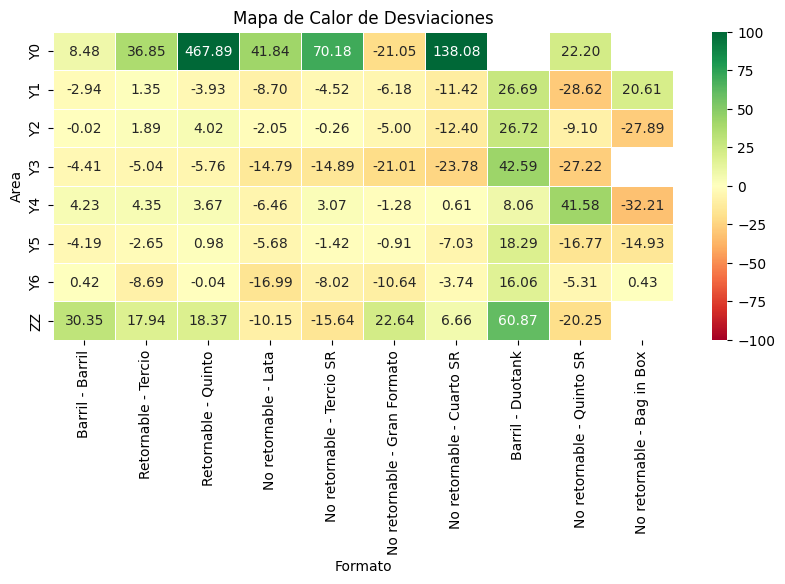

In [85]:
# Graficar mapa de calor de UNE
# -----------------------------------------------------------------------------
plot_heatmap(df_analysis, negocio='UNE')

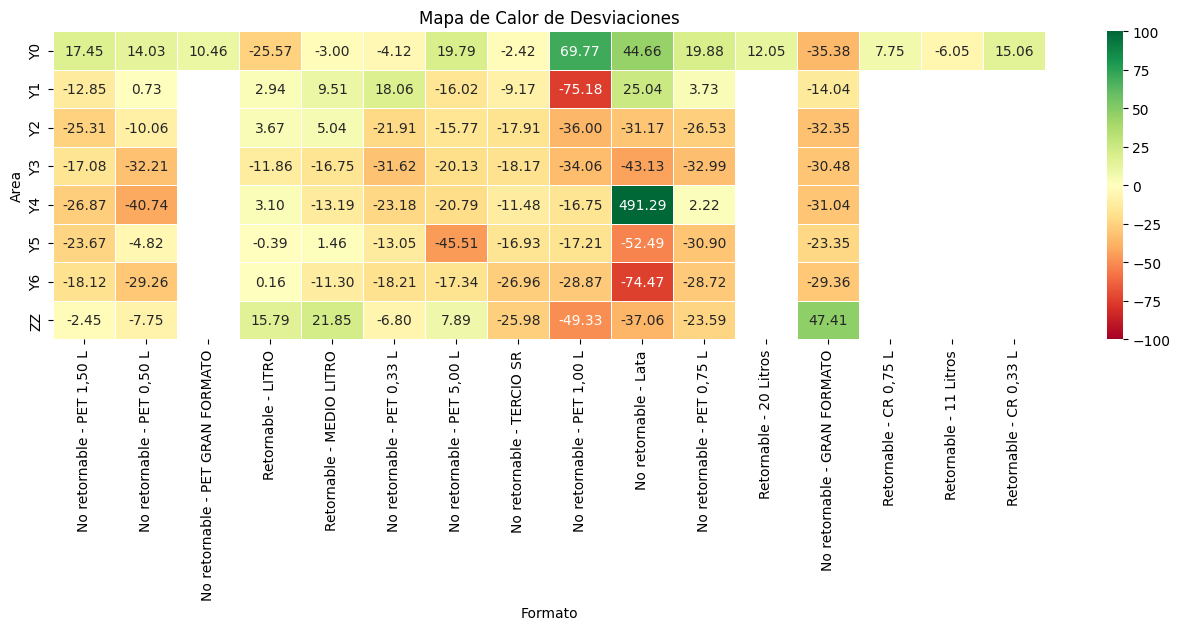

In [86]:
# Graficar mapa de calor de UNA
# -----------------------------------------------------------------------------
plot_heatmap(df_analysis, negocio='UNA')

Modelo particularizados:

- Barril
- Tercio
- Quinto
- Tercio SR